<a href="https://colab.research.google.com/github/N16H7W1N6/WIAI_project_2021/blob/main/WIAI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Connecting Kaggle with GoogleDrive

In [ ]:
!pip install -q kaggle
!pip install -q kaggle-cli
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json
# For competition datasets
#!kaggle competitions download -c dataset_name -p /content/drive/MyDrive/Datasets
# For other datasets
#!kaggle datasets download -d user/dataset_name -p /content/drive/MyDrive/Datasets
!kaggle datasets download -d arashnic/hr-analytics-job-change-of-data-scientists -p /content/drive/MyDrive/Datasets

     |████████████████████████████████| 74 kB 2.3 MB/s 
     |████████████████████████████████| 4.2 MB 34.8 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 144 kB 58.4 MB/s 
     |████████████████████████████████| 111 kB 73.0 MB/s 
  ERROR: Failed building wheel for lxml
    Running setup.py install for lxml ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-sw4p4mgc/lxml_6a2fc6ff3f7146179f76963e32fcce48/setup.py'"'"'; __file__='"'"'/tmp/pip-install-sw4p4mgc/lxml_6a2fc6ff3f7146179f76963e32fcce48/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-j2rplljh/install-record.txt --s

# Understanding the DataSet / Preliminary Data Processing
Problem Statement:

The objective is to build a model which will predict wheather a person is going to change the job or not?

In [ ]:
!pip install missingno
!pip install -U imbalanced-learn

from imblearn.over_sampling import SMOTE
import missingno
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, log_loss, plot_roc_curve, auc, precision_recall_curve
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV

     |████████████████████████████████| 189 kB 8.7 MB/s 
     |████████████████████████████████| 23.1 MB 4.8 kB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [ ]:
!unzip "/content/drive/MyDrive/Datasets/hr-analytics-job-change-of-data-scientists.zip"

Archive:  /content/drive/MyDrive/Datasets/hr-analytics-job-change-of-data-scientists.zip
  inflating: aug_test.csv            
  inflating: aug_train.csv           
  inflating: sample_submission.csv   


In [ ]:
df_train = pd.read_csv("aug_train.csv")
df_test = pd.read_csv("aug_test.csv")

In [ ]:
df_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [ ]:
df_test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   object 
 2   city_development_index  2129 non-null   float64
 3   gender                  1621 non-null   object 
 4   relevent_experience     2129 non-null   object 
 5   enrolled_university     2098 non-null   object 
 6   education_level         2077 non-null   object 
 7   major_discipline        1817 non-null   object 
 8   experience              2124 non-null   object 
 9   company_size            1507 non-null   object 
 10  company_type            1495 non-null   object 
 11  last_new_job            2089 non-null   object 
 12  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 216.4+ KB


In [ ]:
#copy df_test to retain original info, ex.: enrollee_id

from copy import deepcopy




df_test_origin = deepcopy(df_test)

In [ ]:
#write a function to clean the train and test dataset separately but with reduced effort

def clean_df(df):
  if "target" in list(df.columns):
    cols_obj = list(df.dtypes[df.dtypes == object].index[1:])

    #plots the object type features against the target set value, and adjusts them to the dataset size
    plt.figure(figsize=[15, 20])

    i = 1
    y, hue = "proportion", "target"

    for f in cols_obj:
        plt.subplot(5, 2, i)
        df[[f, "target"]]\
            .value_counts(normalize=True)\
            .rename(y)\
            .reset_index()\
            .pipe((sns.barplot, "data"), x=f, y="proportion", hue="target", alpha=0.8)
        plt.title("Proportion of {}  by target".format(f))
        i += 1
    plt.tight_layout()
    plt.show()

  else:
    print("Target not in Dataset")

  #check for duplicates and removed them afterwards

  if len(df[df.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(df[df.duplicated()]))
    print(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).head())
    df.drop_duplicates(inplace=True)
    print("Duplicates were removed.")
  else:
    print("No duplicated entries found.")

  #check for missing numbers

  mis_val = df.isnull().sum()
        
  mis_val_percent = 100 * df.isnull().sum() / len(df)
  mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
  mis_val_table_ren_columns = mis_val_table.rename(
  columns = {0 : "Missing Values", 1 : "% of Total Values"})
        
  mis_val_table_ren_columns = mis_val_table_ren_columns[
  mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
  "% of Total Values", ascending=False).round(1)
        
  print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
  "There are " + str(mis_val_table_ren_columns.shape[0]) +
  " columns that have missing values.")
        
  print(mis_val_table_ren_columns)

  # generate preview of entries with null values
  missingno.matrix(df)
  plt.show()


  
  #LabelEncoder

  le = preprocessing.LabelEncoder()

  list_cols_non_numeric = ["education_level", "company_size", "company_type", "last_new_job", "major_discipline", "enrolled_university", "relevent_experience", "gender", "experience"]

  for var in list_cols_non_numeric:
    df[var] = df[var].fillna("NaN")
    df[var] = le.fit_transform(df[var])

  df.loc[:,"city"] = le.fit_transform(df.loc[:,"city"])

  df.drop(["enrollee_id"], axis=1)
  print("Enrollee_id was removed.")


  #Further approaches to Handle Missing values in Categorical Features**
#1. You can simply **drop columns** having very large amount of null values
#2. Drop entire rows** if it has some null values. But this approach is not Recommendable because then we will lose lots of precious data.
#3. First convert none null categorical data into numarical form and then simply **fill mean, mode or median** value inplace of null values
#4. First convert none null categorical data into numarical form and then **with the help of k-Nearest Neighbors** algorithm find missing values and **impute** them in data
#5. Another way of imputing missing values in a column would be to **train a regression model that tries to predict missing values in a column based on other columns**.

  #correlation
  #Here I try to measure correlation in data using Correlation coefficients.

  #Correlation coefficients are used to measure how strong a relationship is between two variables.
  #The formulas return a value between -1 and 1, where:

  #1 indicates a strong positive relationship.
  #-1 indicates a strong negative relationship.
  #A result of zero indicates no relationship at all.

  corr = df.corr()
  print(corr)

  #plotting correlations # to complete

  # prefer boxplot (ex.: city_devlopment_index, experience (numeric)) for each feature & barplot for company_type, education_level

  var_numeric = ["city_development_index", "training_hours"]
  var_non_numeric = ["company_type", "experience"]

  df.corr()[var_numeric].plot.box(figsize = (15,10))

  # heatmap

  #define figure size
  sns.set(rc={"figure.figsize":(15, 20)}) #width=15, height=20
  #display heatmap
  sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, square=True, cmap="RdYlGn")
  plt.title("Correlation between features")

  #Modelling
  if "target" in list(df.columns):
    Y = df["target"]
    X = df.drop(columns=["target"])
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=9)

    #define figure size
    sns.set(rc={"figure.figsize":(5, 5)}) #width=5, height=5
    plt.figure()
    sns.countplot(df["target"], edgecolor = "black")

    smote = SMOTE(random_state = 402)
    X_smote, Y_smote = smote.fit_resample(X,Y)
    plt.figure()
    sns.countplot(Y_smote)
  
  else:
    pass

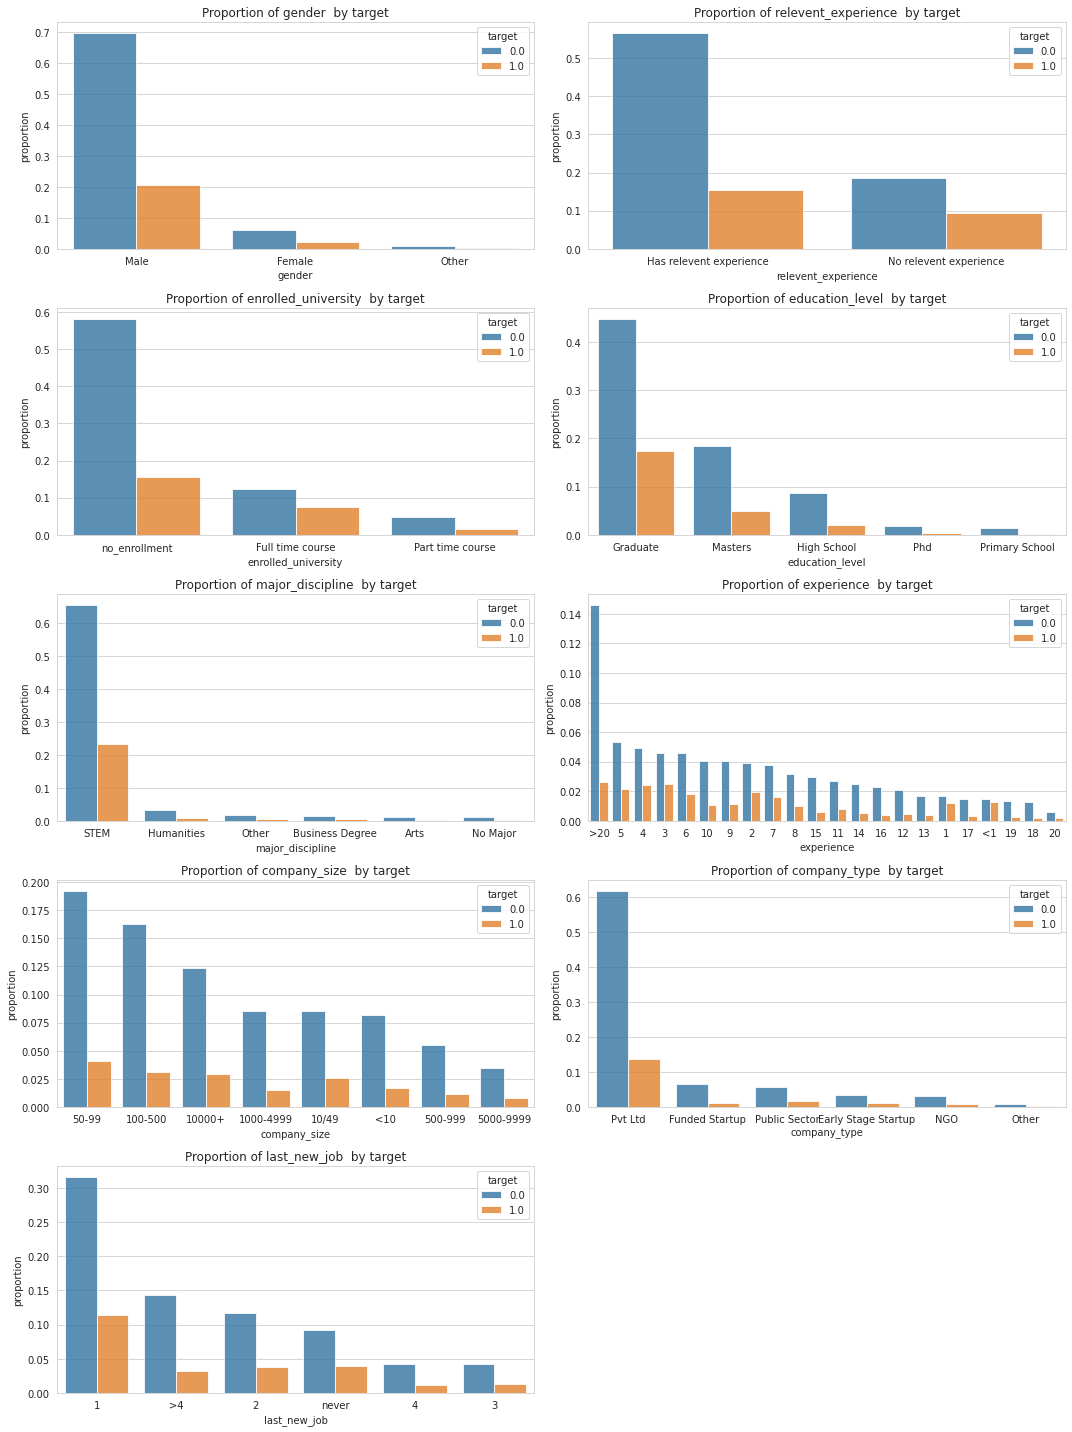

No duplicated entries found.
Your selected dataframe has 14 columns.
There are 8 columns that have missing values.
                     Missing Values  % of Total Values
company_type                   6140               32.0
company_size                   5938               31.0
gender                         4508               23.5
major_discipline               2813               14.7
education_level                 460                2.4
last_new_job                    423                2.2
enrolled_university             386                2.0
experience                       65                0.3


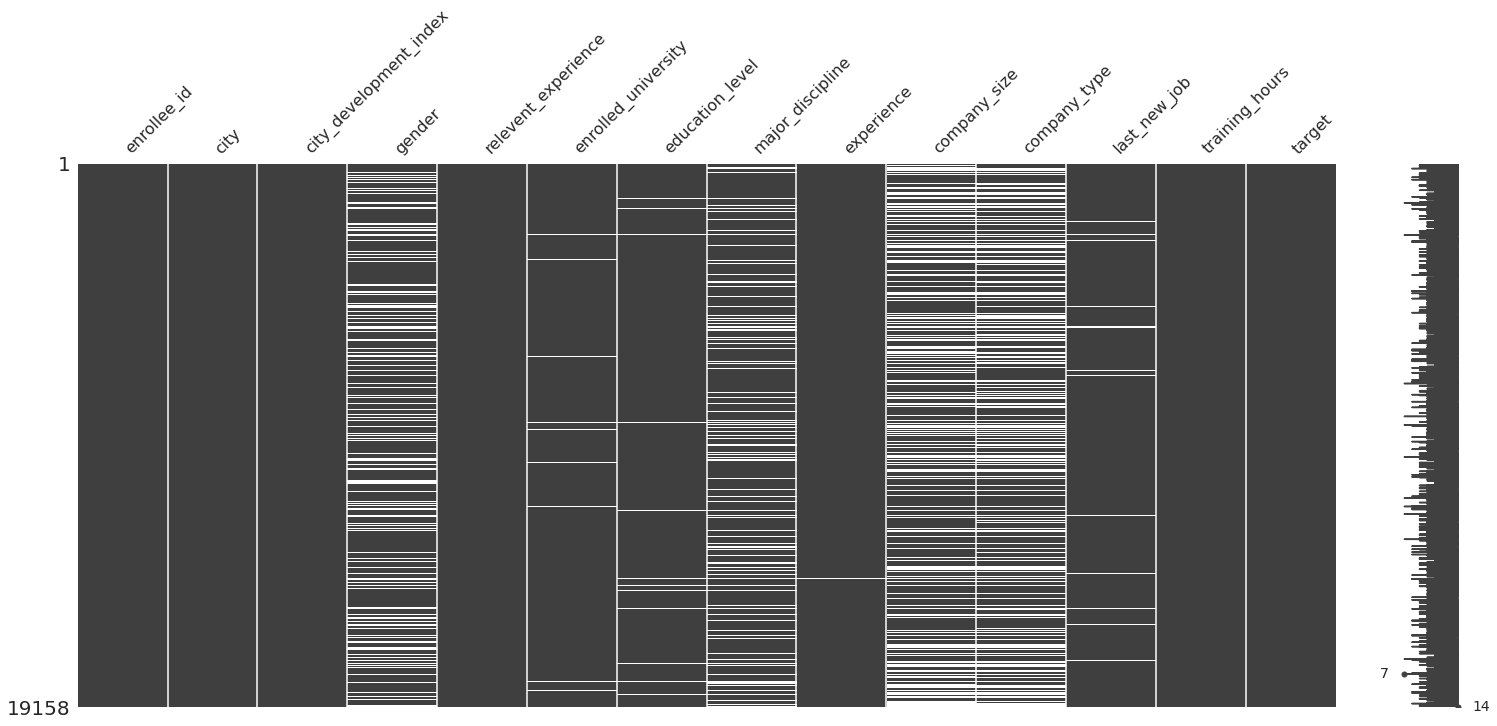

Enrollee_id was removed.
                        enrollee_id      city  ...  training_hours    target
enrollee_id                1.000000 -0.011566  ...        0.000998  0.049475
city                      -0.011566  1.000000  ...        0.009537  0.056233
city_development_index    -0.040455 -0.326104  ...        0.001920 -0.341665
gender                    -0.042894  0.045932  ...       -0.000060  0.055275
relevent_experience        0.043359  0.006154  ...       -0.011566  0.128430
enrolled_university       -0.033577 -0.075369  ...        0.004100 -0.155292
education_level           -0.028066  0.001793  ...       -0.007868 -0.083964
major_discipline          -0.016849  0.068920  ...       -0.002242  0.047924
experience                -0.000272 -0.042545  ...       -0.005202 -0.006335
company_size               0.020814  0.026963  ...       -0.003124  0.186114
company_type              -0.027299 -0.020115  ...       -0.009791 -0.118953
last_new_job              -0.034903  0.001763  ... 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Target not in Dataset
No duplicated entries found.
Your selected dataframe has 13 columns.
There are 8 columns that have missing values.
                     Missing Values  % of Total Values
company_type                    634               29.8
company_size                    622               29.2
gender                          508               23.9
major_discipline                312               14.7
education_level                  52                2.4
last_new_job                     40                1.9
enrolled_university              31                1.5
experience                        5                0.2


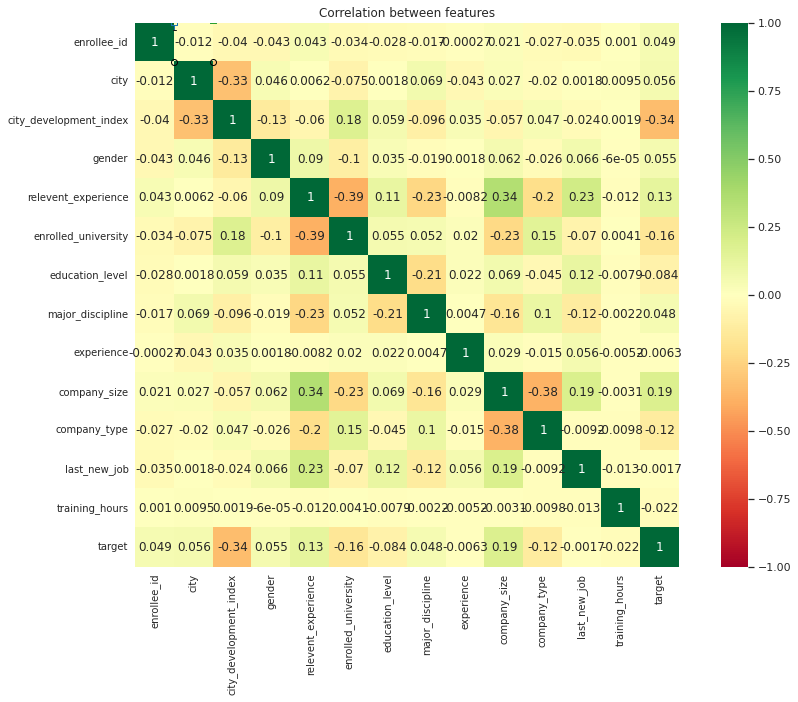

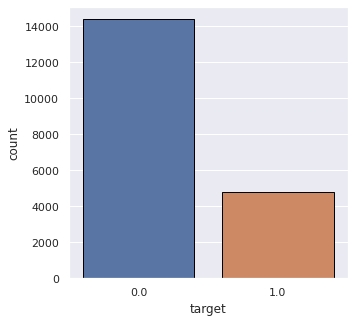

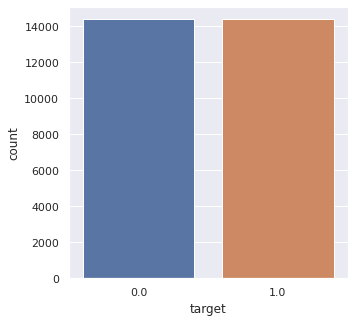

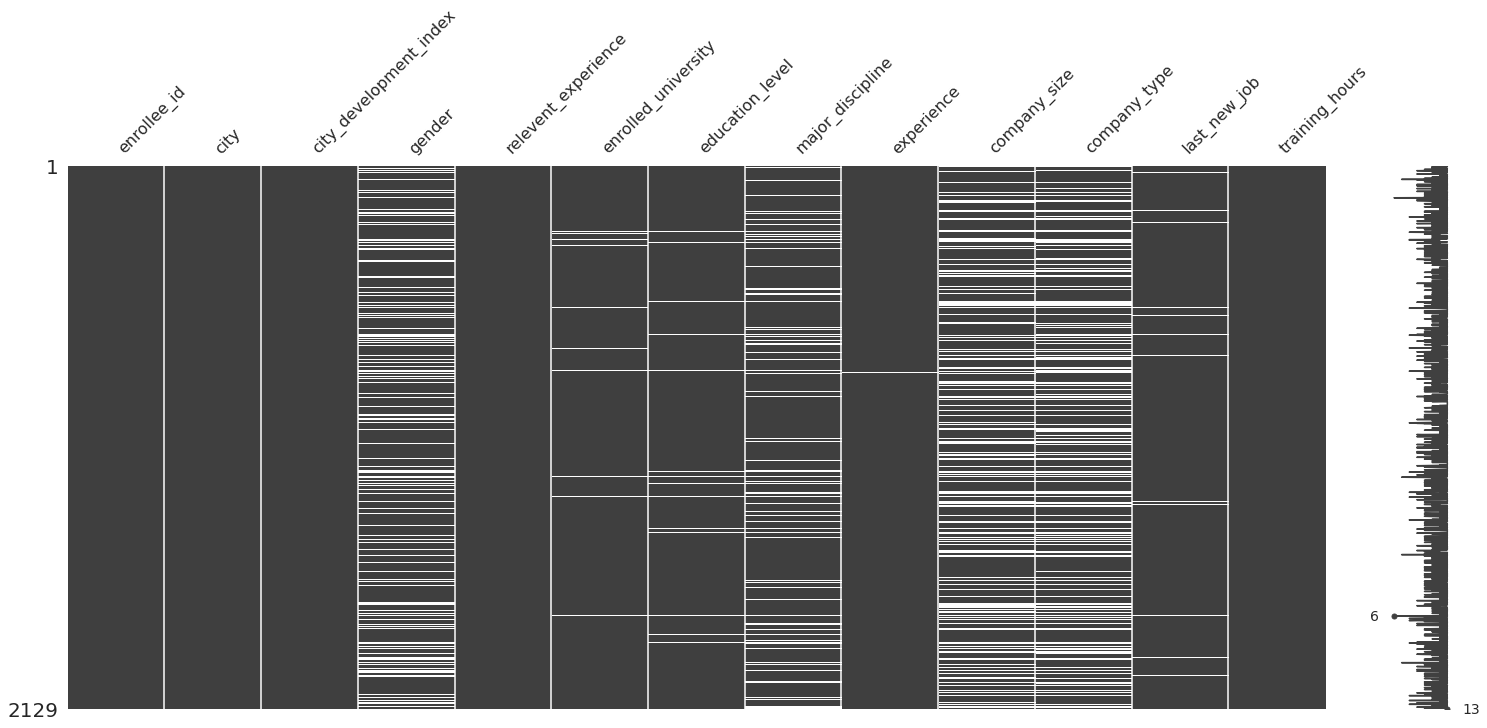

Enrollee_id was removed.
                        enrollee_id      city  ...  last_new_job  training_hours
enrollee_id                1.000000  0.019533  ...     -0.007586        0.003239
city                       0.019533  1.000000  ...     -0.039991        0.036087
city_development_index    -0.045087 -0.323608  ...     -0.017865       -0.022653
gender                    -0.036208  0.037717  ...      0.105089        0.001137
relevent_experience        0.014973 -0.016469  ...      0.197539       -0.004855
enrolled_university        0.013726 -0.058244  ...     -0.058490        0.004926
education_level           -0.020385 -0.053629  ...      0.124732        0.030517
major_discipline          -0.014147  0.063250  ...     -0.100427        0.012837
experience                 0.023172 -0.021967  ...      0.043267       -0.007182
company_size               0.024636  0.014151  ...      0.165425        0.004227
company_type              -0.013439  0.004684  ...      0.017218       -0.031989
las

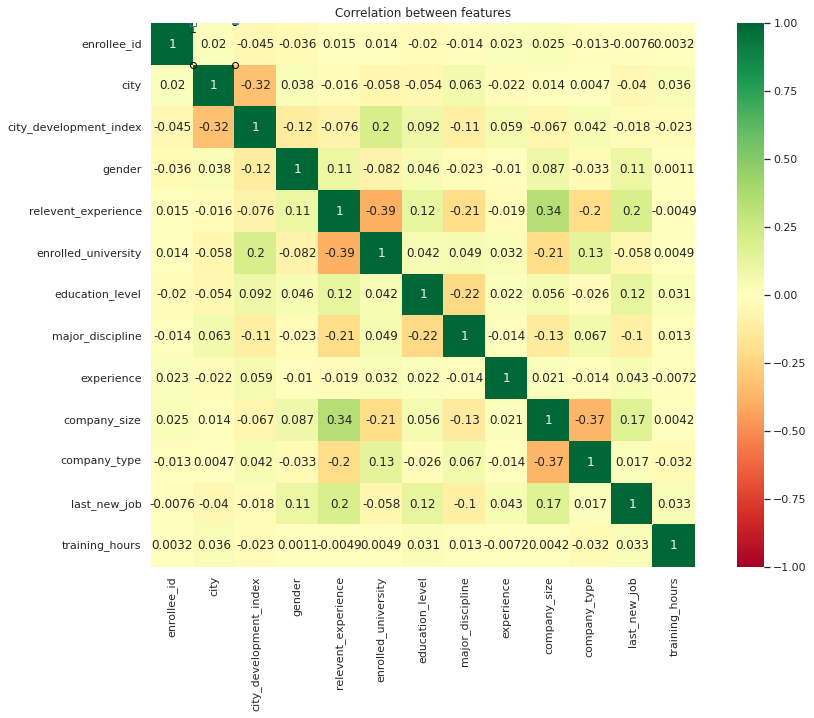

In [ ]:
## To start off, we read in our dataset and generate a simple preview and statistics of our data.

clean_df(df_train)
clean_df(df_test)

Column "Target" is missing in test dataset<br>
We can already see a lot of missing values<br> <br>
**Variable Description**
<br>
- enrollee_id : Unique ID for enrollee
- city : City code
- city_development_index : Developement index of the city (scaled)
- gender : Registered person gender (M/F/Other)
- relevent_experience : Relevent experience
- enrolled_university : Type of university of the enrolee
- education_level : edu level
- major_discipline : edu discipline of enrollee
- experience : Total experience in years
- company_size : No of employees in current employer's company
- company_type : Type of current employer
- last_new_job : Difference in years between previous job and current job
- training_hours : training hours completed
- target : 0 – Not looking for job change, 1 – Looking for a job change

The probability of the search for a new job is increasing with the following features:

- men
- working (no_enrollment)
- STEM background
- current company type PVT LTD (Private limited company, NAO)
- with 1 job experience

In [ ]:
#How shall I proceed: Apply the same procedure on the test data set or rather combine from the beginning the training + test data set and split them while modeling?
# Kavita recommended to use the train dataset separately, then apply the model to the test dataset in parallel or afterwards, ex.: creating functions -done
# using only .fit --> only training dataset and .transform --> test set
# feature engineering after train_test_split

#Modelling

In [ ]:
#feature_columns = ["city_development_index", "gender", "relevent_experience", "enrolled_university", "education_level", "major_discipline", "experience", "company_size", "company_type","last_new_job",	"training_hours"]

In [ ]:
# template / function:
#k means clustering
# k-nearest neighbors
# decision tree
# logistic regression
# ... --> print scores + compare
#gridsearch --> hyperparameter tuning

##Model Building

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve

In [ ]:
X_train = df_train.drop(columns=["target"]).values
y_train = df_train["target"].values

X_test = df_test.values

# split of df_train into df_train_train and df_train_test to validate the model bc given df_train has no target column
# We will use df_train for prediction

X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y_train, test_size=0.3, random_state=80)

In [ ]:
model = list()
resample = list()
precision = list()
recall = list()
F1score = list()
AUCROC = list()

In [ ]:
#create a function to validate the model

def test_eval(clf_model, X_test, y_test, algo=None, sampling=None):
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test)
    y_pred=clf_model.predict(X_test)

    print("Confusion Matrix")
    print("="*60)
    plot_confusion_matrix(clf_model, X_test, y_test)  
    plt.show() 
    #print(confusion_matrix(y_test,y_pred),"\n")
    print("Classification Report")
    print("="*60)
    print(classification_report(y_test,y_pred),"\n")
    print("AUC-ROC")
    print("="*60)
    print(roc_auc_score(y_test, y_prob[:,1]))
          
    model.append(algo)
    precision.append(precision_score(y_test,y_pred))
    recall.append(recall_score(y_test,y_pred))
    F1score.append(f1_score(y_test,y_pred))
    AUCROC.append(roc_auc_score(y_test, y_prob[:,1]))
    resample.append(sampling)

Model-1: Logistic Regression

In [ ]:
log_model=LogisticRegression()
clf_LR = log_model.fit(X_train_train, y_train_train)

Confusion Matrix


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


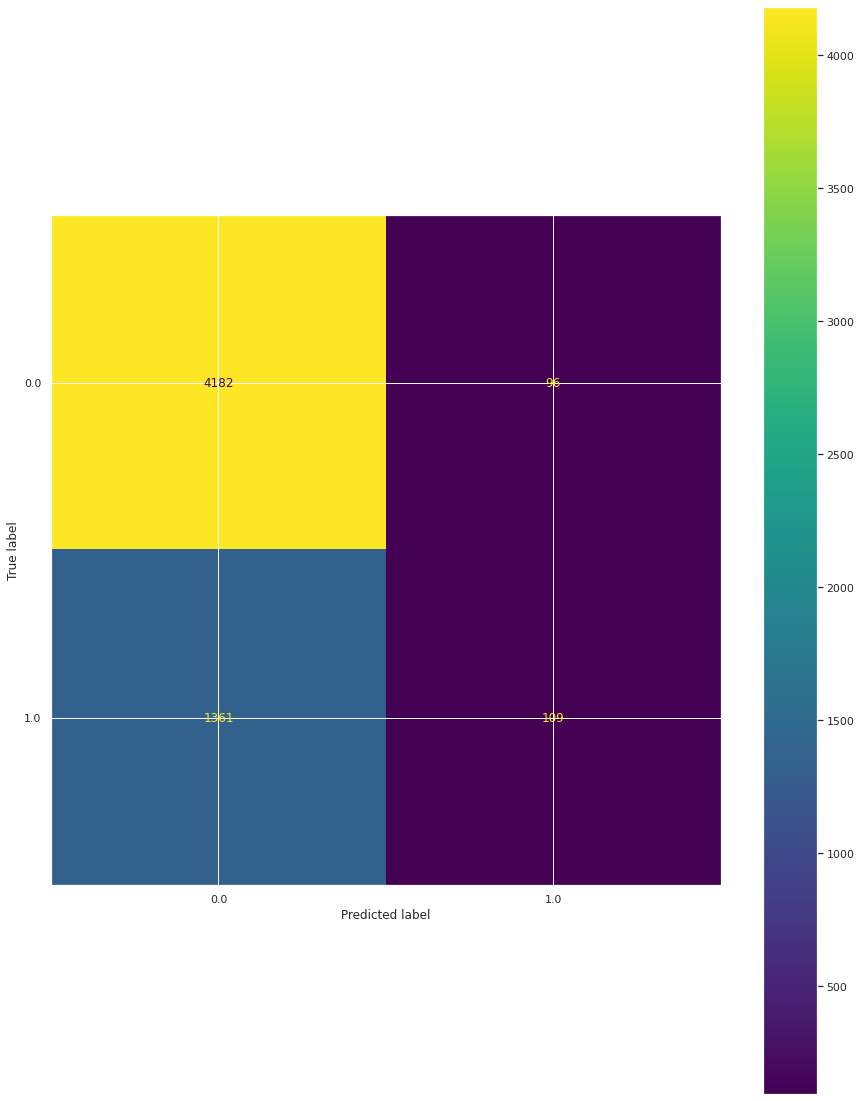

Classification Report
              precision    recall  f1-score   support

         0.0       0.75      0.98      0.85      4278
         1.0       0.53      0.07      0.13      1470

    accuracy                           0.75      5748
   macro avg       0.64      0.53      0.49      5748
weighted avg       0.70      0.75      0.67      5748
 

AUC-ROC
0.6550443178673994


In [ ]:
test_eval(clf_LR, X_train_test, y_train_test, "Logistic Regression", "actual")

Model-2: Decision Tree

In [ ]:
#estimators = [2,10,30,50,100]
# Maximum number of depth in each tree:
##max_depth = [i for i in range(5,16,2)]
# Minimum number of samples to consider to split a node:
#min_samples_split = [2, 5, 10, 15, 20, 50, 100]
# Minimum number of samples to consider at each leaf node:
#min_samples_leaf = [1, 2, 5]
#Impurity
#criterion = ['gini', 'entropy']
#The number of features to consider when looking for the best split
#max_features = ['log2', 'sqrt', 'auto']

In [ ]:
tree_model = DecisionTreeClassifier()
clf_DT = tree_model.fit(X_train_train, y_train_train)
#tree_param_grid = { 
#    'max_features':max_features,
#    'criterion':criterion,
#    'max_depth': max_depth,
#    'min_samples_split': min_samples_split,
#    'min_samples_leaf': min_samples_leaf
#}

#clf_DT = RandomizedSearchCV(tree_model, tree_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
#clf_DT.fit(X_train, Y_train)
#clf_DT.best_estimator_

Confusion Matrix


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


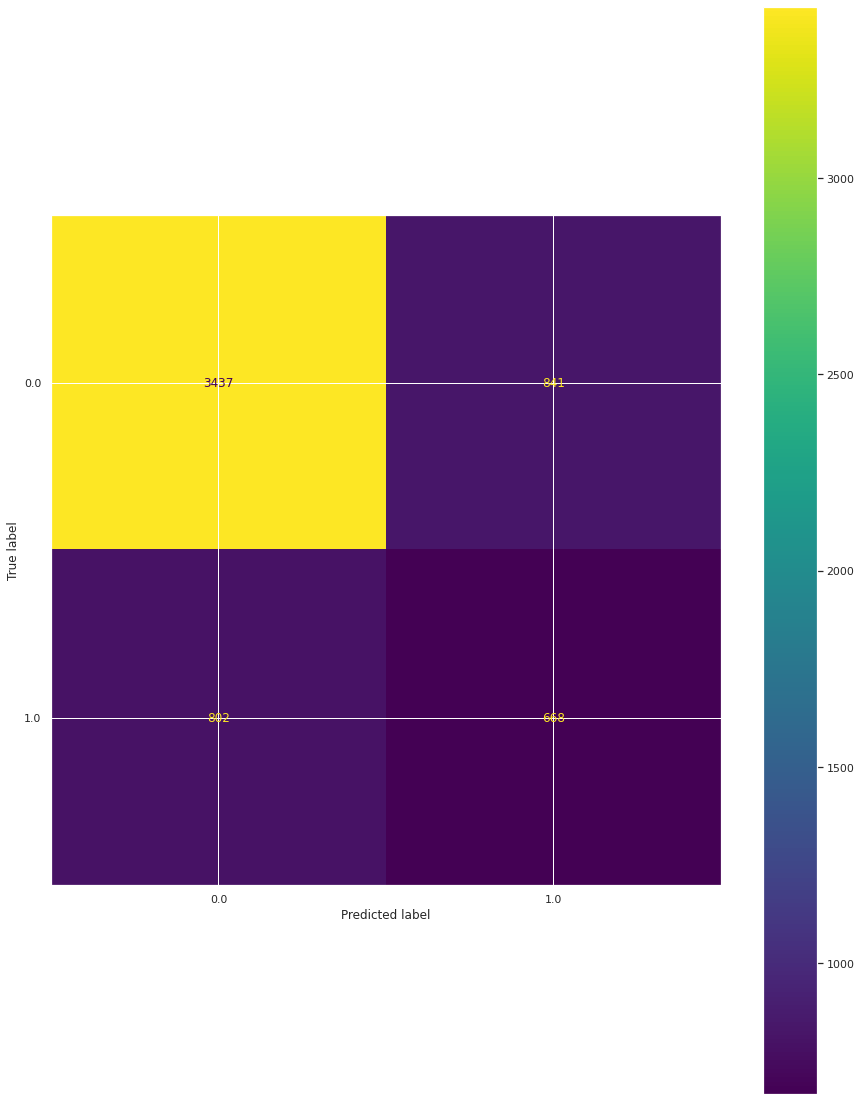

Classification Report
              precision    recall  f1-score   support

         0.0       0.81      0.80      0.81      4278
         1.0       0.44      0.45      0.45      1470

    accuracy                           0.71      5748
   macro avg       0.63      0.63      0.63      5748
weighted avg       0.72      0.71      0.72      5748
 

AUC-ROC
0.6289172892158266


In [ ]:
test_eval(clf_DT, X_train_test, y_train_test, "Decision Tree", "actual")

Model-3: k-nearest neighbors

In [ ]:
knn_model = KNeighborsClassifier()

# Create the knn model.
# Look at the five closest neighbors.
knn = KNeighborsClassifier(n_neighbors=5)
# Fit the model on the training data.
clf_knn = knn.fit(X_train_train, y_train_train)

Confusion Matrix


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


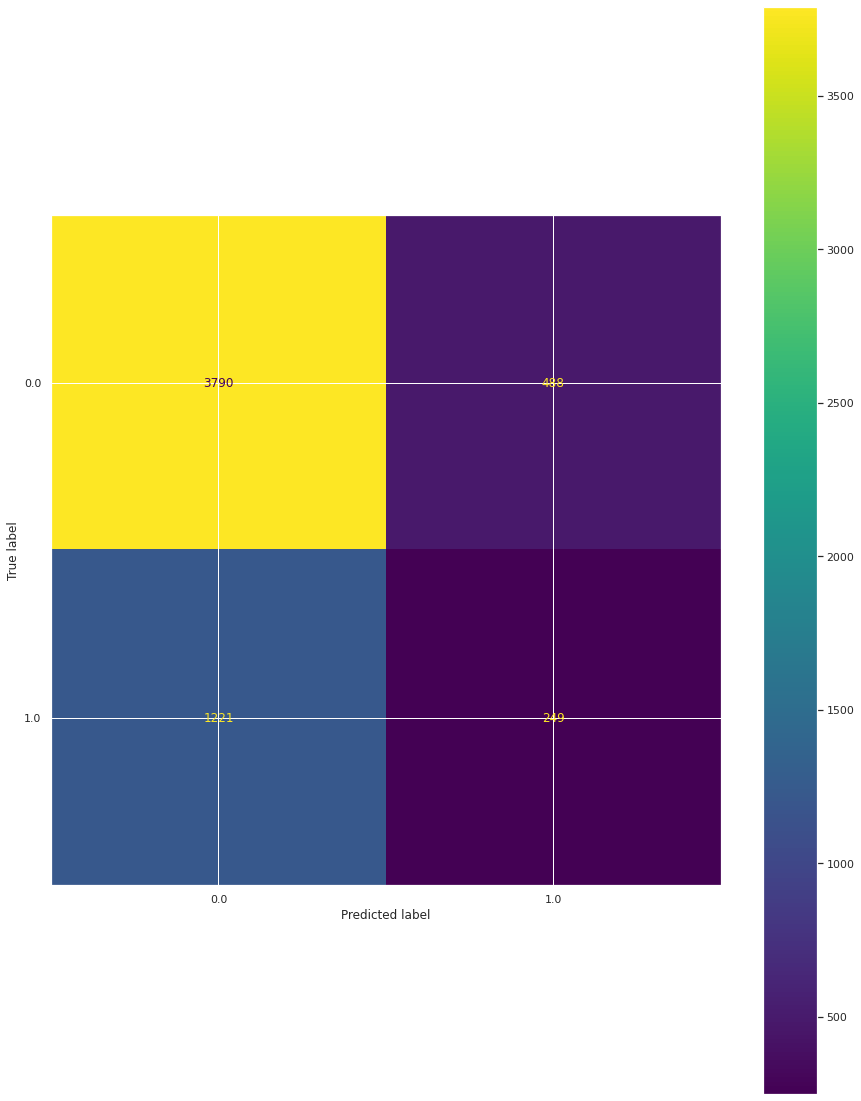

Classification Report
              precision    recall  f1-score   support

         0.0       0.76      0.89      0.82      4278
         1.0       0.34      0.17      0.23      1470

    accuracy                           0.70      5748
   macro avg       0.55      0.53      0.52      5748
weighted avg       0.65      0.70      0.67      5748
 

AUC-ROC
0.556549010441016


In [ ]:
test_eval(clf_knn, X_train_test, y_train_test, "k-nearest neigbors", "actual")

Model-4: Radom Forest

In [ ]:
Random_Forest_model = RandomForestClassifier()
clf_RF = Random_Forest_model.fit(X_train_train, y_train_train)

Confusion Matrix


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


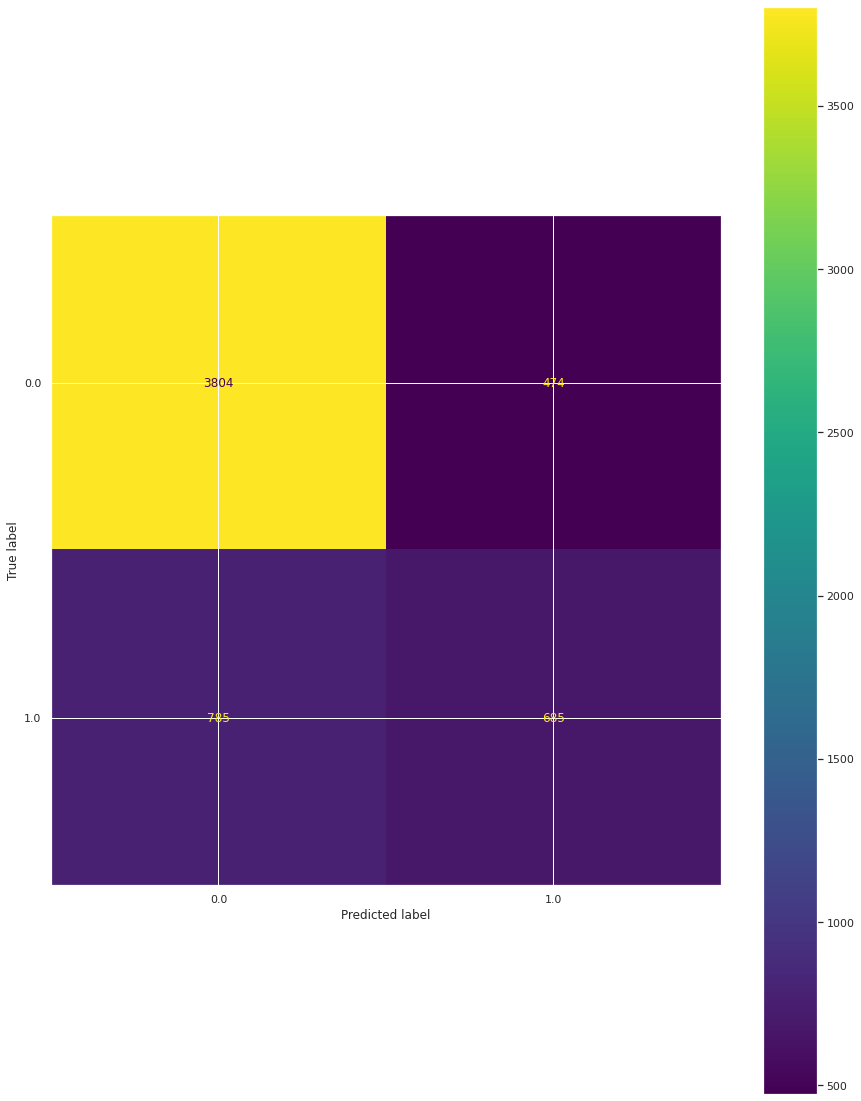

Classification Report
              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      4278
         1.0       0.59      0.47      0.52      1470

    accuracy                           0.78      5748
   macro avg       0.71      0.68      0.69      5748
weighted avg       0.77      0.78      0.77      5748
 

AUC-ROC
0.7974808623776766


In [ ]:
test_eval(clf_RF, X_train_test, y_train_test, "Random Forest", "actual")

##Model Comparision

In [ ]:
clf_eval_df = pd.DataFrame({"model":model,
                            "resample":resample,
                            "precision":precision,
                            "recall":recall,
                            "f1-score":F1score,
                            "AUC-ROC":AUCROC})
clf_eval_df

,model,resample,precision,recall,f1-score,AUC-ROC
0,Logistic Regression,actual,0.531707,0.074150,0.130149,0.655044
1,Decision Tree,actual,0.442677,0.454422,0.448473,0.628917
2,k-nearest neigbors,actual,0.337856,0.169388,0.225646,0.556549
3,Random Forest,actual,0.591027,0.465986,0.521111,0.797481


## Evaluation Metrics

**Accuracy :** It is one of the most straightforward metrics used in machine learning. It defines how accurate your model is. For example, if you build a model that classifies 90 samples accurately, your accuracy is 90% or 0.90. If only 83 samples are classified correctly, the accuracy of your model is 83% or 0.83. Simple.

**Precision :** Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answer is of all passengers that labeled as survived, how many actually survived? High precision relates to the low false positive rate.

**True Positives (TP)**- These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes. E.g. if actual class value indicates that this passenger survived and predicted class tells you the same thing.

**True Negatives (TN)**- These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no. E.g. if actual class says this passenger did not survive and predicted class tells you the same thing.

False positives and false negatives, these values occur when your actual class contradicts with the predicted class.

**False Positives (FP)** – When actual class is no and predicted class is yes. E.g. if actual class says this passenger did not survive but predicted class tells you that this passenger will survive.

**False Negatives (FN)** – When actual class is yes but predicted class in no. E.g. if actual class value indicates that this passenger survived and predicted class tells you that passenger will die.

**Recall(Sensitivity)** : Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes. The question recall answers is: Of all the passengers that truly survived, how many did we label? good = above 0.5.


**Confusion Matrix :** A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix.


**F1 score (F1) :** F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall.

**Area under the ROC (Receiver Operating Characteristic) curve :** AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s. By analogy, the Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease.

#Hyperparameter Optimization With Grid Search

A range of different optimization algorithms may be used, although two of the simplest and most common methods are random search and grid search.

*   Random Search. Define a search space as a bounded domain of hyperparameter values and randomly sample points in that domain.
*   Grid Search. Define a search space as a grid of hyperparameter values and evaluate every position in the grid.

Grid search is great for spot-checking combinations that are known to perform well generally. Random search is great for discovery and getting hyperparameter combinations that you would not have guessed intuitively, although it often requires more time to execute.

In [ ]:
#opt_log_model.get_params().keys()

In [ ]:
#clf_LR
opt_log_model=LogisticRegression(max_iter=1000)

params={'C':np.logspace(-10, 1, 15),"class_weight":[None,"balanced"]}

cv = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

#Create grid search using 5-fold cross validation

opt_clf_LR = GridSearchCV(opt_log_model, params, cv=cv, scoring="roc_auc", n_jobs=-1)
opt_clf_LR.fit(X_train_train, y_train_train)
opt_clf_LR.best_estimator_

LogisticRegression(C=0.26826957952797276, class_weight='balanced',
                   max_iter=1000)

Confusion Matrix


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


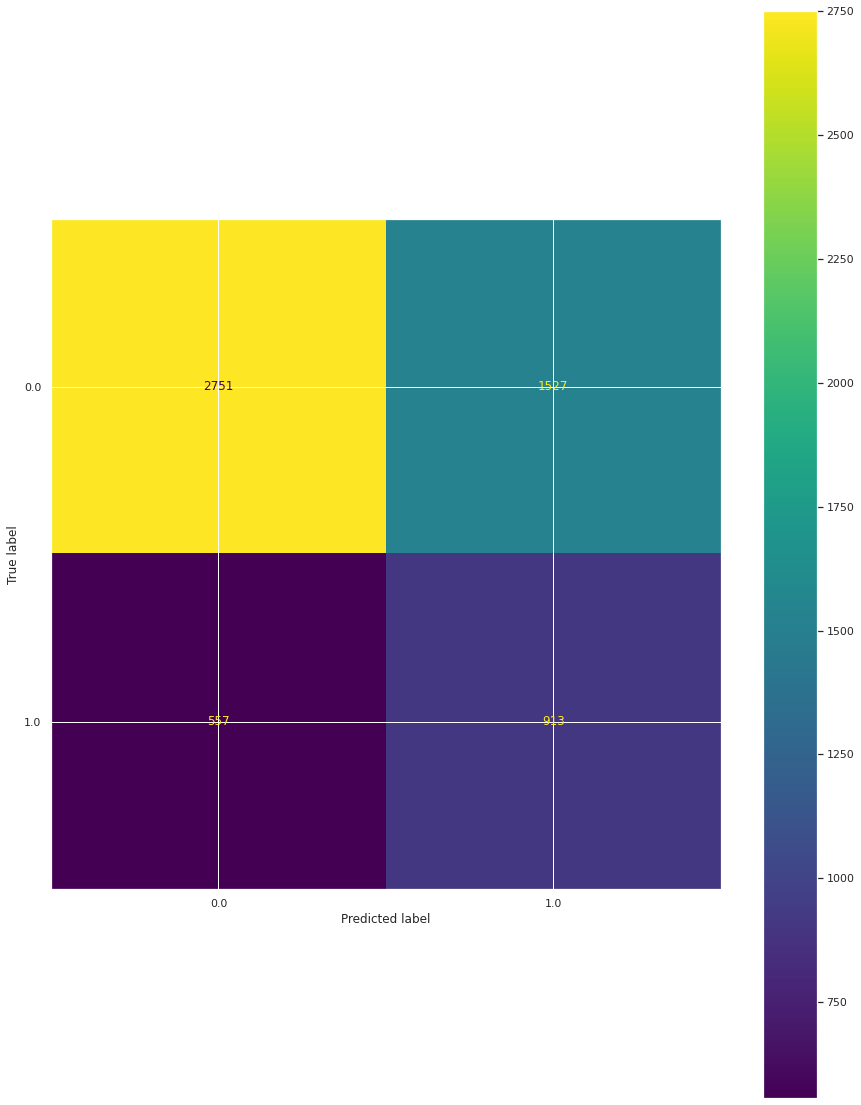

Classification Report
              precision    recall  f1-score   support

         0.0       0.83      0.64      0.73      4278
         1.0       0.37      0.62      0.47      1470

    accuracy                           0.64      5748
   macro avg       0.60      0.63      0.60      5748
weighted avg       0.71      0.64      0.66      5748
 

AUC-ROC
0.6732896992364034


In [ ]:
test_eval(opt_clf_LR, X_train_test, y_train_test, "Opt Logistic Regression", "actual")

In [ ]:
#opt_Random_Forest_model.get_params().keys()

In [ ]:
opt_Random_Forest_model = RandomForestClassifier()
grid_search = {"max_depth": [5,10]}
opt_clf_RF = GridSearchCV(estimator = opt_Random_Forest_model, param_grid = grid_search, cv = 4, verbose= 5, n_jobs = -1) 
opt_clf_RF.fit(X_train_train,y_train_train)

Fitting 4 folds for each of 2 candidates, totalling 8 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10]}, verbose=5)

Confusion Matrix


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


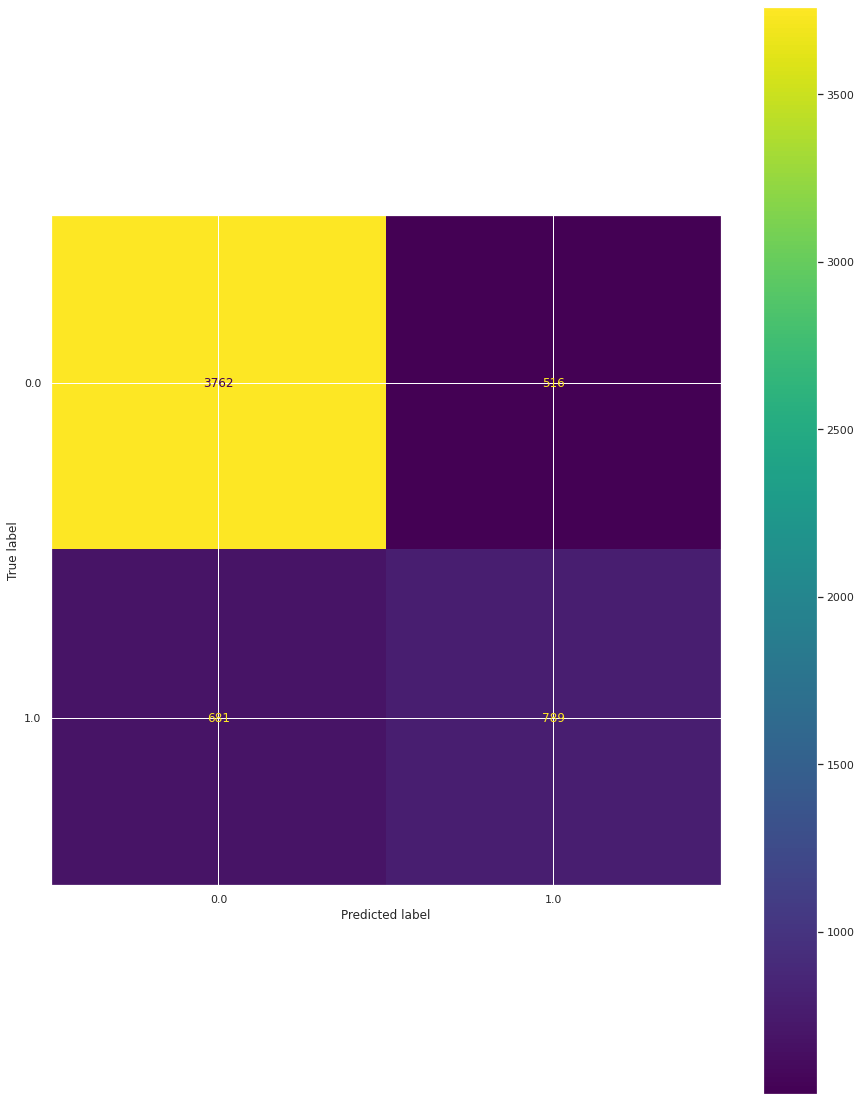

Classification Report
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86      4278
         1.0       0.60      0.54      0.57      1470

    accuracy                           0.79      5748
   macro avg       0.73      0.71      0.72      5748
weighted avg       0.78      0.79      0.79      5748
 

AUC-ROC
0.8069490956738002


In [ ]:
test_eval(opt_clf_RF, X_train_test, y_train_test, "Opt Random Forest", "actual")

## Model Comparison with optimized parameters

In [ ]:
clf_eval_df = pd.DataFrame({"model":model,
                            "resample":resample,
                            "precision":precision,
                            "recall":recall,
                            "f1-score":F1score,
                            "AUC-ROC":AUCROC})
clf_eval_df

,model,resample,precision,recall,f1-score,AUC-ROC
0,Logistic Regression,actual,0.531707,0.074150,0.130149,0.655044
1,Decision Tree,actual,0.442677,0.454422,0.448473,0.628917
2,k-nearest neigbors,actual,0.337856,0.169388,0.225646,0.556549
3,Random Forest,actual,0.591027,0.465986,0.521111,0.797481
4,Opt Logistic Regression,actual,0.374180,0.621088,0.467008,0.673290
5,Opt Random Forest,actual,0.604598,0.536735,0.568649,0.806949


##Prediction

Application to df_test

In [ ]:
X_pred = df_test.values
y_pred =opt_clf_RF.predict(X_pred)

df_test_origin["result"]= y_pred

In [ ]:
df_test_origin[["enrollee_id", "result"]]

,enrollee_id,result
0,32403,0.0
1,9858,0.0
2,31806,0.0
3,27385,0.0
4,27724,0.0
...,...,...
2124,1289,0.0
2125,195,0.0
2126,31762,0.0
2127,7873,0.0
